In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display, Image
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical



## Read in new data set
---

In [37]:
df = pd.read_csv("df_rolling_window_imputation.csv")


array([[<Axes: title={'center': 'activity'}>,
        <Axes: title={'center': 'appCat.builtin'}>,
        <Axes: title={'center': 'appCat.communication'}>],
       [<Axes: title={'center': 'appCat.entertainment'}>,
        <Axes: title={'center': 'appCat.other'}>,
        <Axes: title={'center': 'appCat.social'}>],
       [<Axes: title={'center': 'call'}>,
        <Axes: title={'center': 'circumplex.arousal'}>,
        <Axes: title={'center': 'circumplex.valence'}>],
       [<Axes: title={'center': 'mood'}>,
        <Axes: title={'center': 'screen'}>,
        <Axes: title={'center': 'sms'}>]], dtype=object)

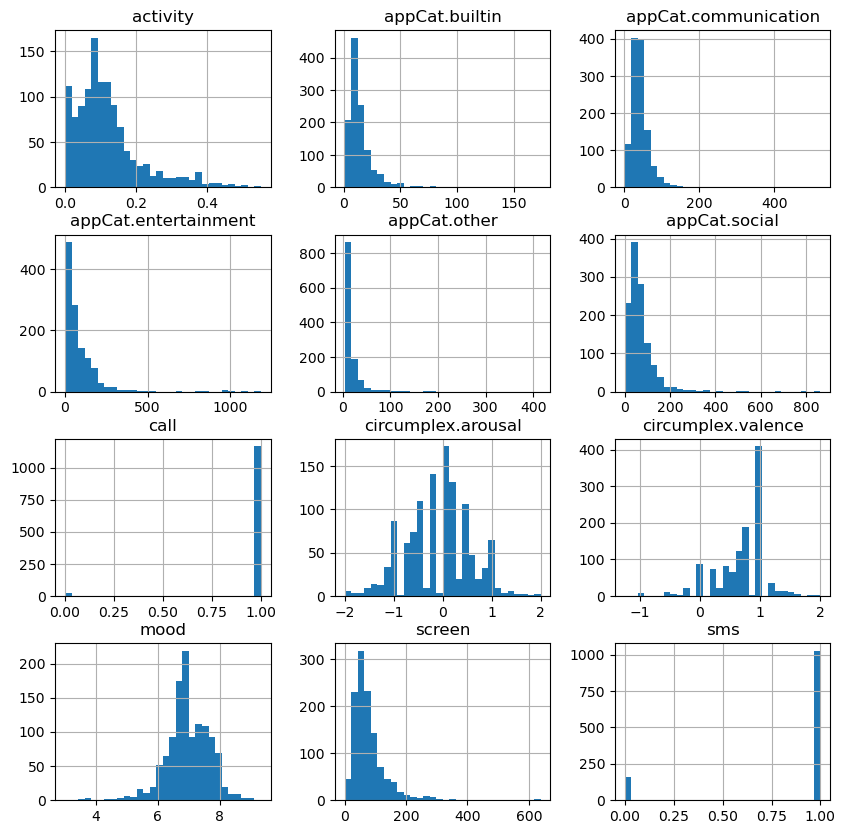

In [38]:
df.hist(bins = 30, figsize=(10,10))

### Preperation for model
---

* ### Replace nan values with mean of column

In [39]:
df.isna().sum()

id                      0
time                    0
activity                0
appCat.builtin          0
appCat.communication    0
appCat.entertainment    0
appCat.other            0
appCat.social           0
call                    0
circumplex.arousal      0
circumplex.valence      0
mood                    0
screen                  0
sms                     0
dtype: int64

## LSTM RNN
---

* ### Setup

<Axes: >

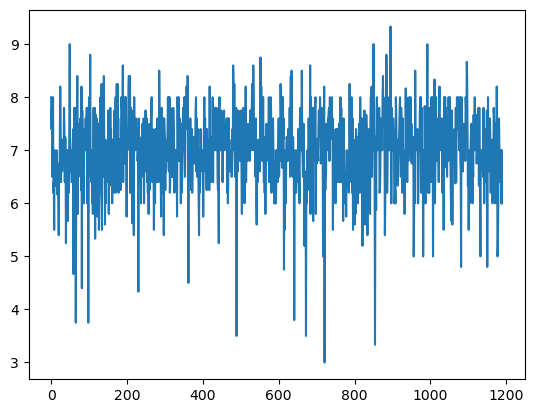

In [42]:
df['mood'].plot()

In [40]:
#Convert mood values to labels
bins = [0, 2, 4, 6, 8, 10]
labels = ['Very Sad', 'Sad', 'Neutral', 'Happy', 'Very Happy']
df['mood_category'] = pd.cut(df['mood'], bins=bins, labels=labels, include_lowest=True)



#Split target and features
x = df.drop(['id','time', 'mood','mood_category'],axis=1) #Exclude time for now, but try including it later!
y = pd.get_dummies(df['mood_category']) #Hot encode y labels so that they can be used in the model

#Normalising the data such that each column has a mean of 0 and a standard deviation of 1 (i.e a Z score)
#"Neural networks' weights are updated by an amount proportional to the partial derivative of the loss function with respect to each weight. If features have very different scales, then the updates made to the weights will also differ in scale, making the learning process unstable. This is particularly critical for deep learning where different layers might have different sensitivities to the scale of input data."
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

#Reshape for model
time_steps = 5
x_scaled = np.array([x_scaled[i - time_steps:i, :] for i in range(time_steps, len(x_scaled) + 1)])
y[time_steps:] #Intuition: We are using day 1 to predict day 2, hence the y vector must start from day 2, as this is the predicted target using day 1's data 
#x_scaled = np.array([x_scaled[i - time_steps:i, :] for i in range(time_steps, len(x_scaled))])


#Split data into training and test
#x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42) # For now we will allocate 20% of the data for testing (allocated randomly with seed of 42)



,Very Sad,Sad,Neutral,Happy,Very Happy
5,0,0,0,1,0
6,0,0,0,1,0
7,0,0,0,1,0
8,0,0,1,0,0
9,0,0,0,1,0
...,...,...,...,...,...
1185,0,0,0,1,0
1186,0,0,0,1,0
1187,0,0,1,0,0
1188,0,0,0,1,0


In [41]:
y

,Very Sad,Sad,Neutral,Happy,Very Happy
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0
...,...,...,...,...,...
1185,0,0,0,1,0
1186,0,0,0,1,0
1187,0,0,1,0,0
1188,0,0,0,1,0


In [33]:
x_scaled.shape

(1186, 5, 11)

* ### Define model


In [19]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])), #The input shape takes te following parameters (time steps, features per time step)
    LSTM(50),
    Dense(y.shape[1], activation='softmax') #Output layer has the same number of neurons as category labels. Activation  function is softMax to output probabilities
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/alex_1/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


* ### Train model

In [20]:
#Train model and randomly select 10% of the data for validation
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6181 - loss: 1.5842 - val_accuracy: 0.8333 - val_loss: 1.5000
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8753 - loss: 1.4484 - val_accuracy: 0.8229 - val_loss: 1.2724
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8669 - loss: 1.1565 - val_accuracy: 0.8229 - val_loss: 0.8571
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8527 - loss: 0.7266 - val_accuracy: 0.8229 - val_loss: 0.6707
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8473 - loss: 0.5815 - val_accuracy: 0.8229 - val_loss: 0.6459
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8640 - loss: 0.4944 - val_accuracy: 0.8229 - val_loss: 0.6057
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8646 - loss: 0.4586 - val_accuracy: 0.8229 - val_loss: 0.5749
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8677 - loss: 0.4434 - val_accuracy: 0.8333 - val_loss: 0.5455
Epo

* ### Evalutation

In [21]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.8560 - loss: 0.4486
Test Accuracy: 86.97%


In [22]:
# mse_training = history.history['loss']
# mse_validation = history.history['val_loss']
# epochs = range(1, len(mse_training) + 1)

In [23]:
# plt.figure(figsize=(10, 6))
# plt.plot(epochs, mse_training, 'bo', label='Training loss')  
# plt.plot(epochs, mse_validation, 'b', label='Validation loss')   
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [24]:
# loss = model.evaluate(x_test, y_test)
# print(f'Test MSE Loss: {loss}')

### Theory
---

* ###  Vanilla RNN

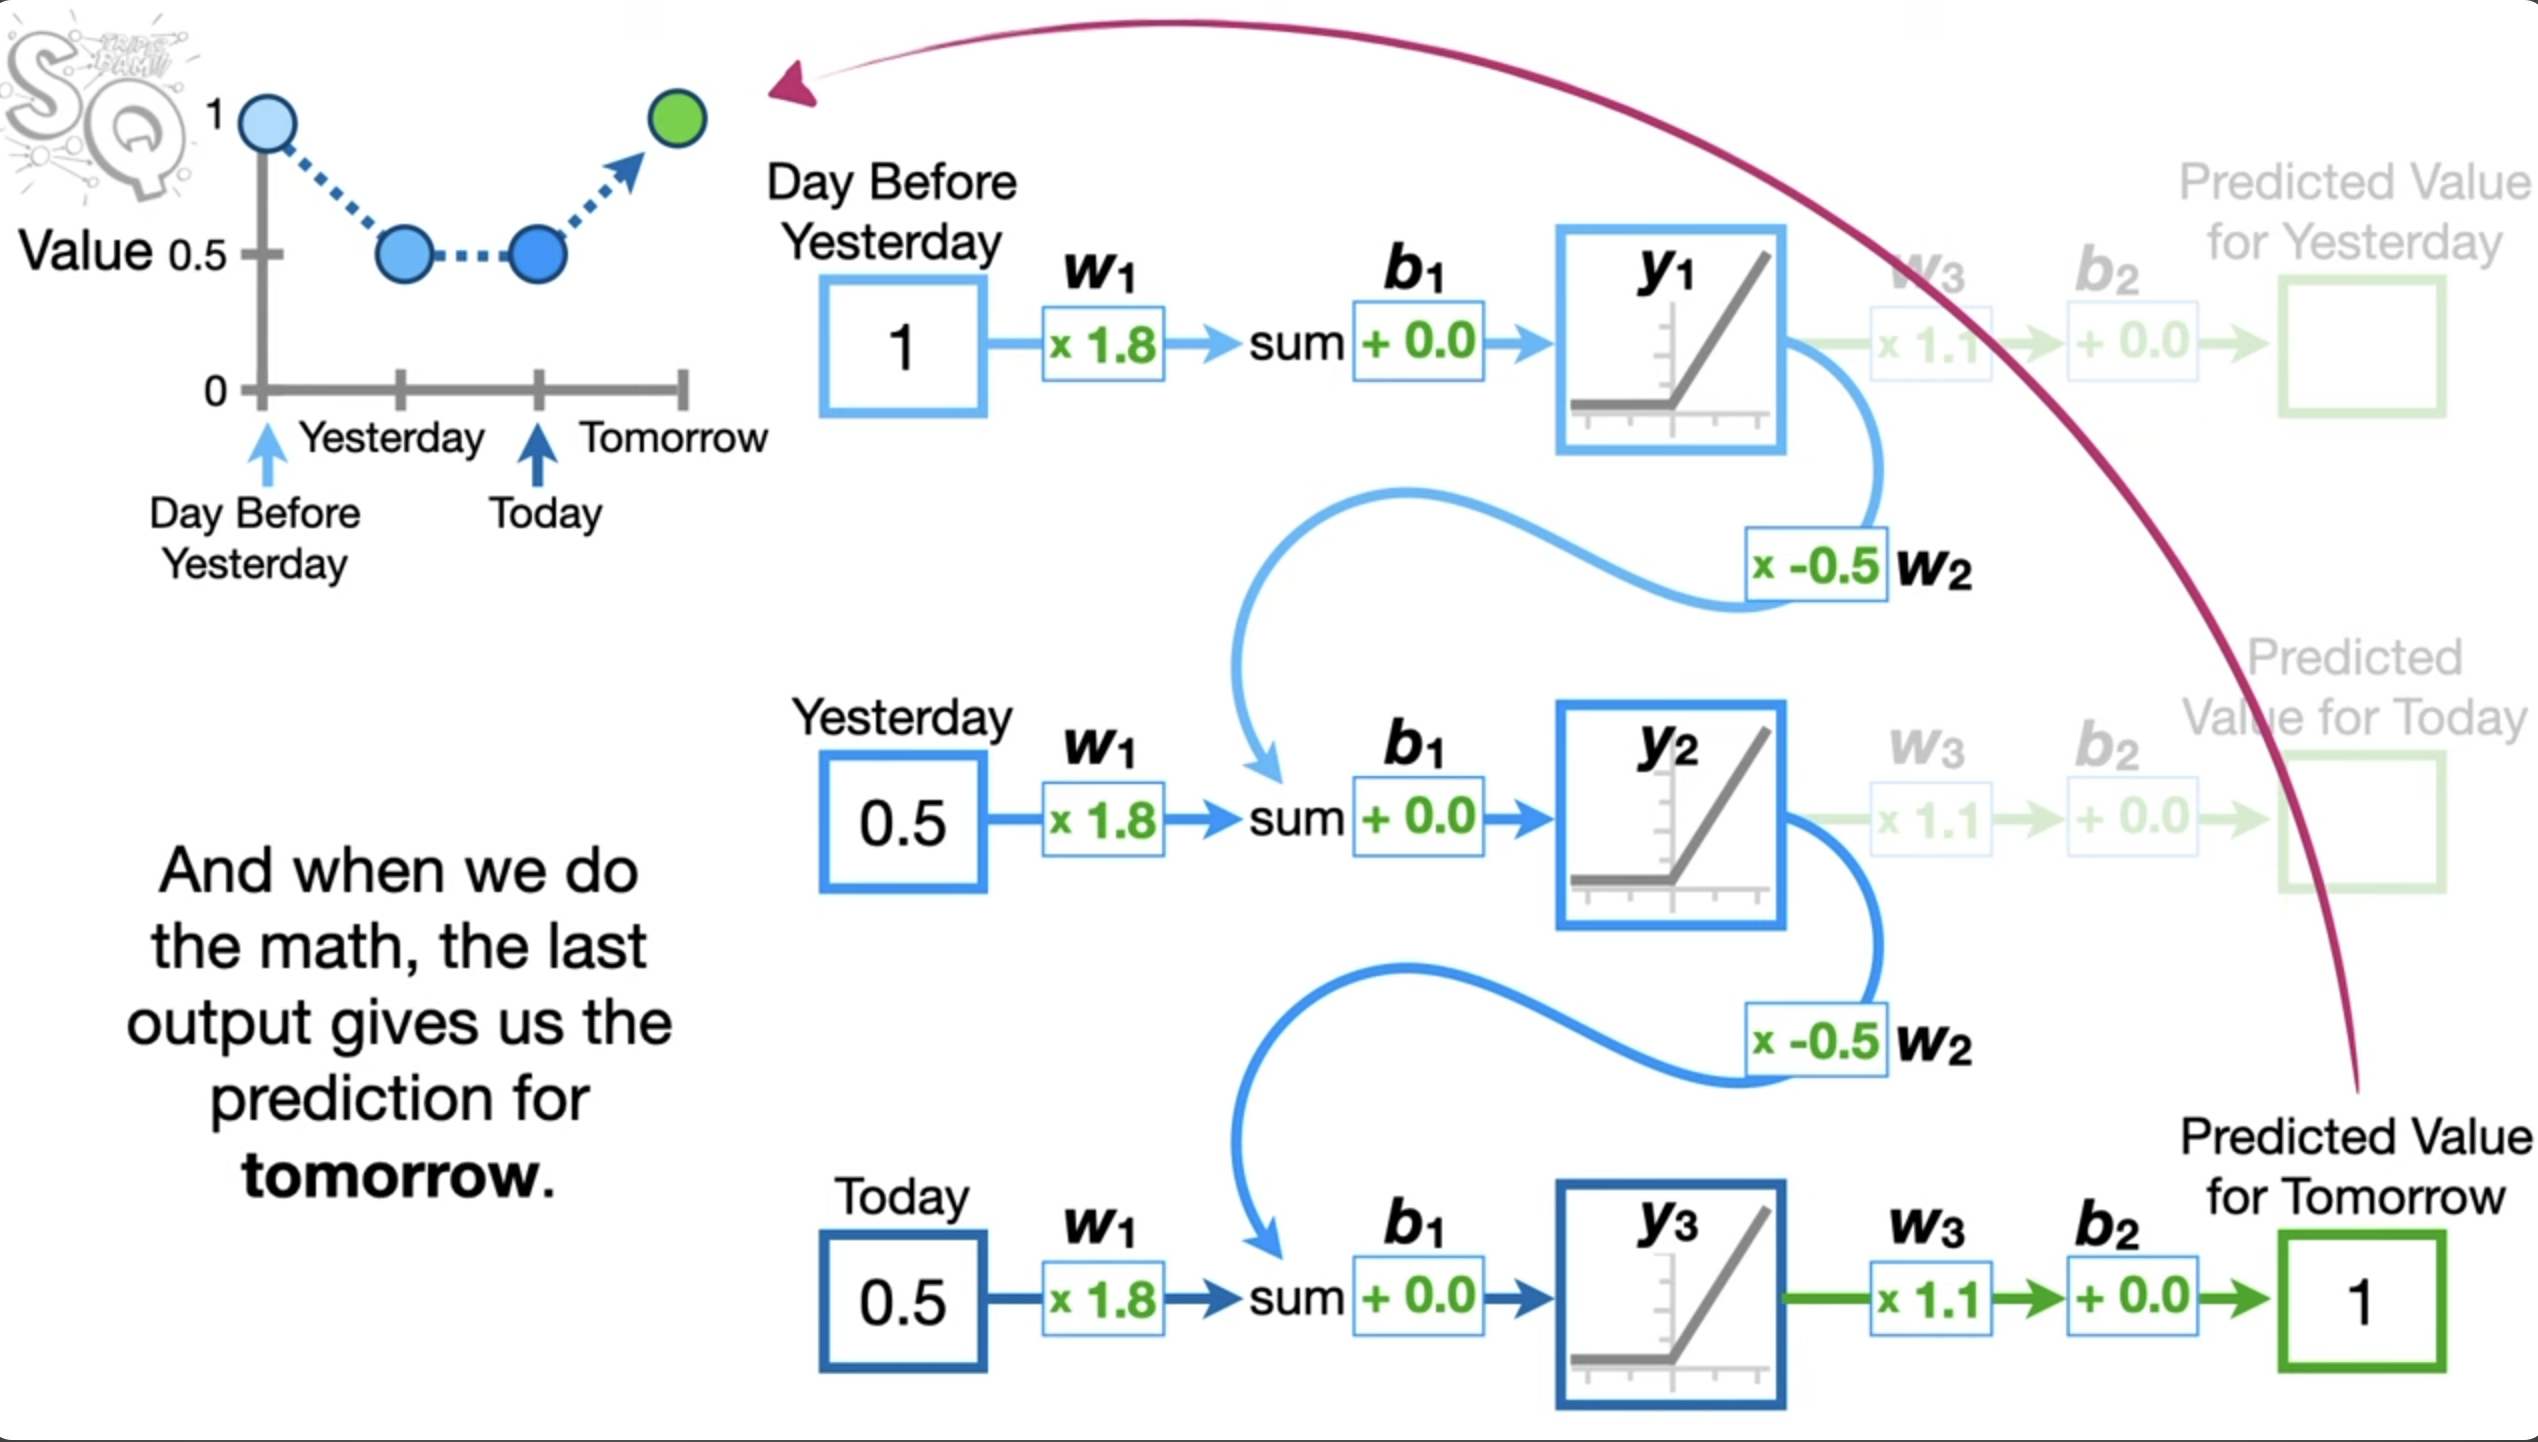

In [25]:
display(Image(filename='RNN.png'))

* ###  LSTM RNN
    * An imporved RNN that fixes the exploding gradient and disappearing gradient problem

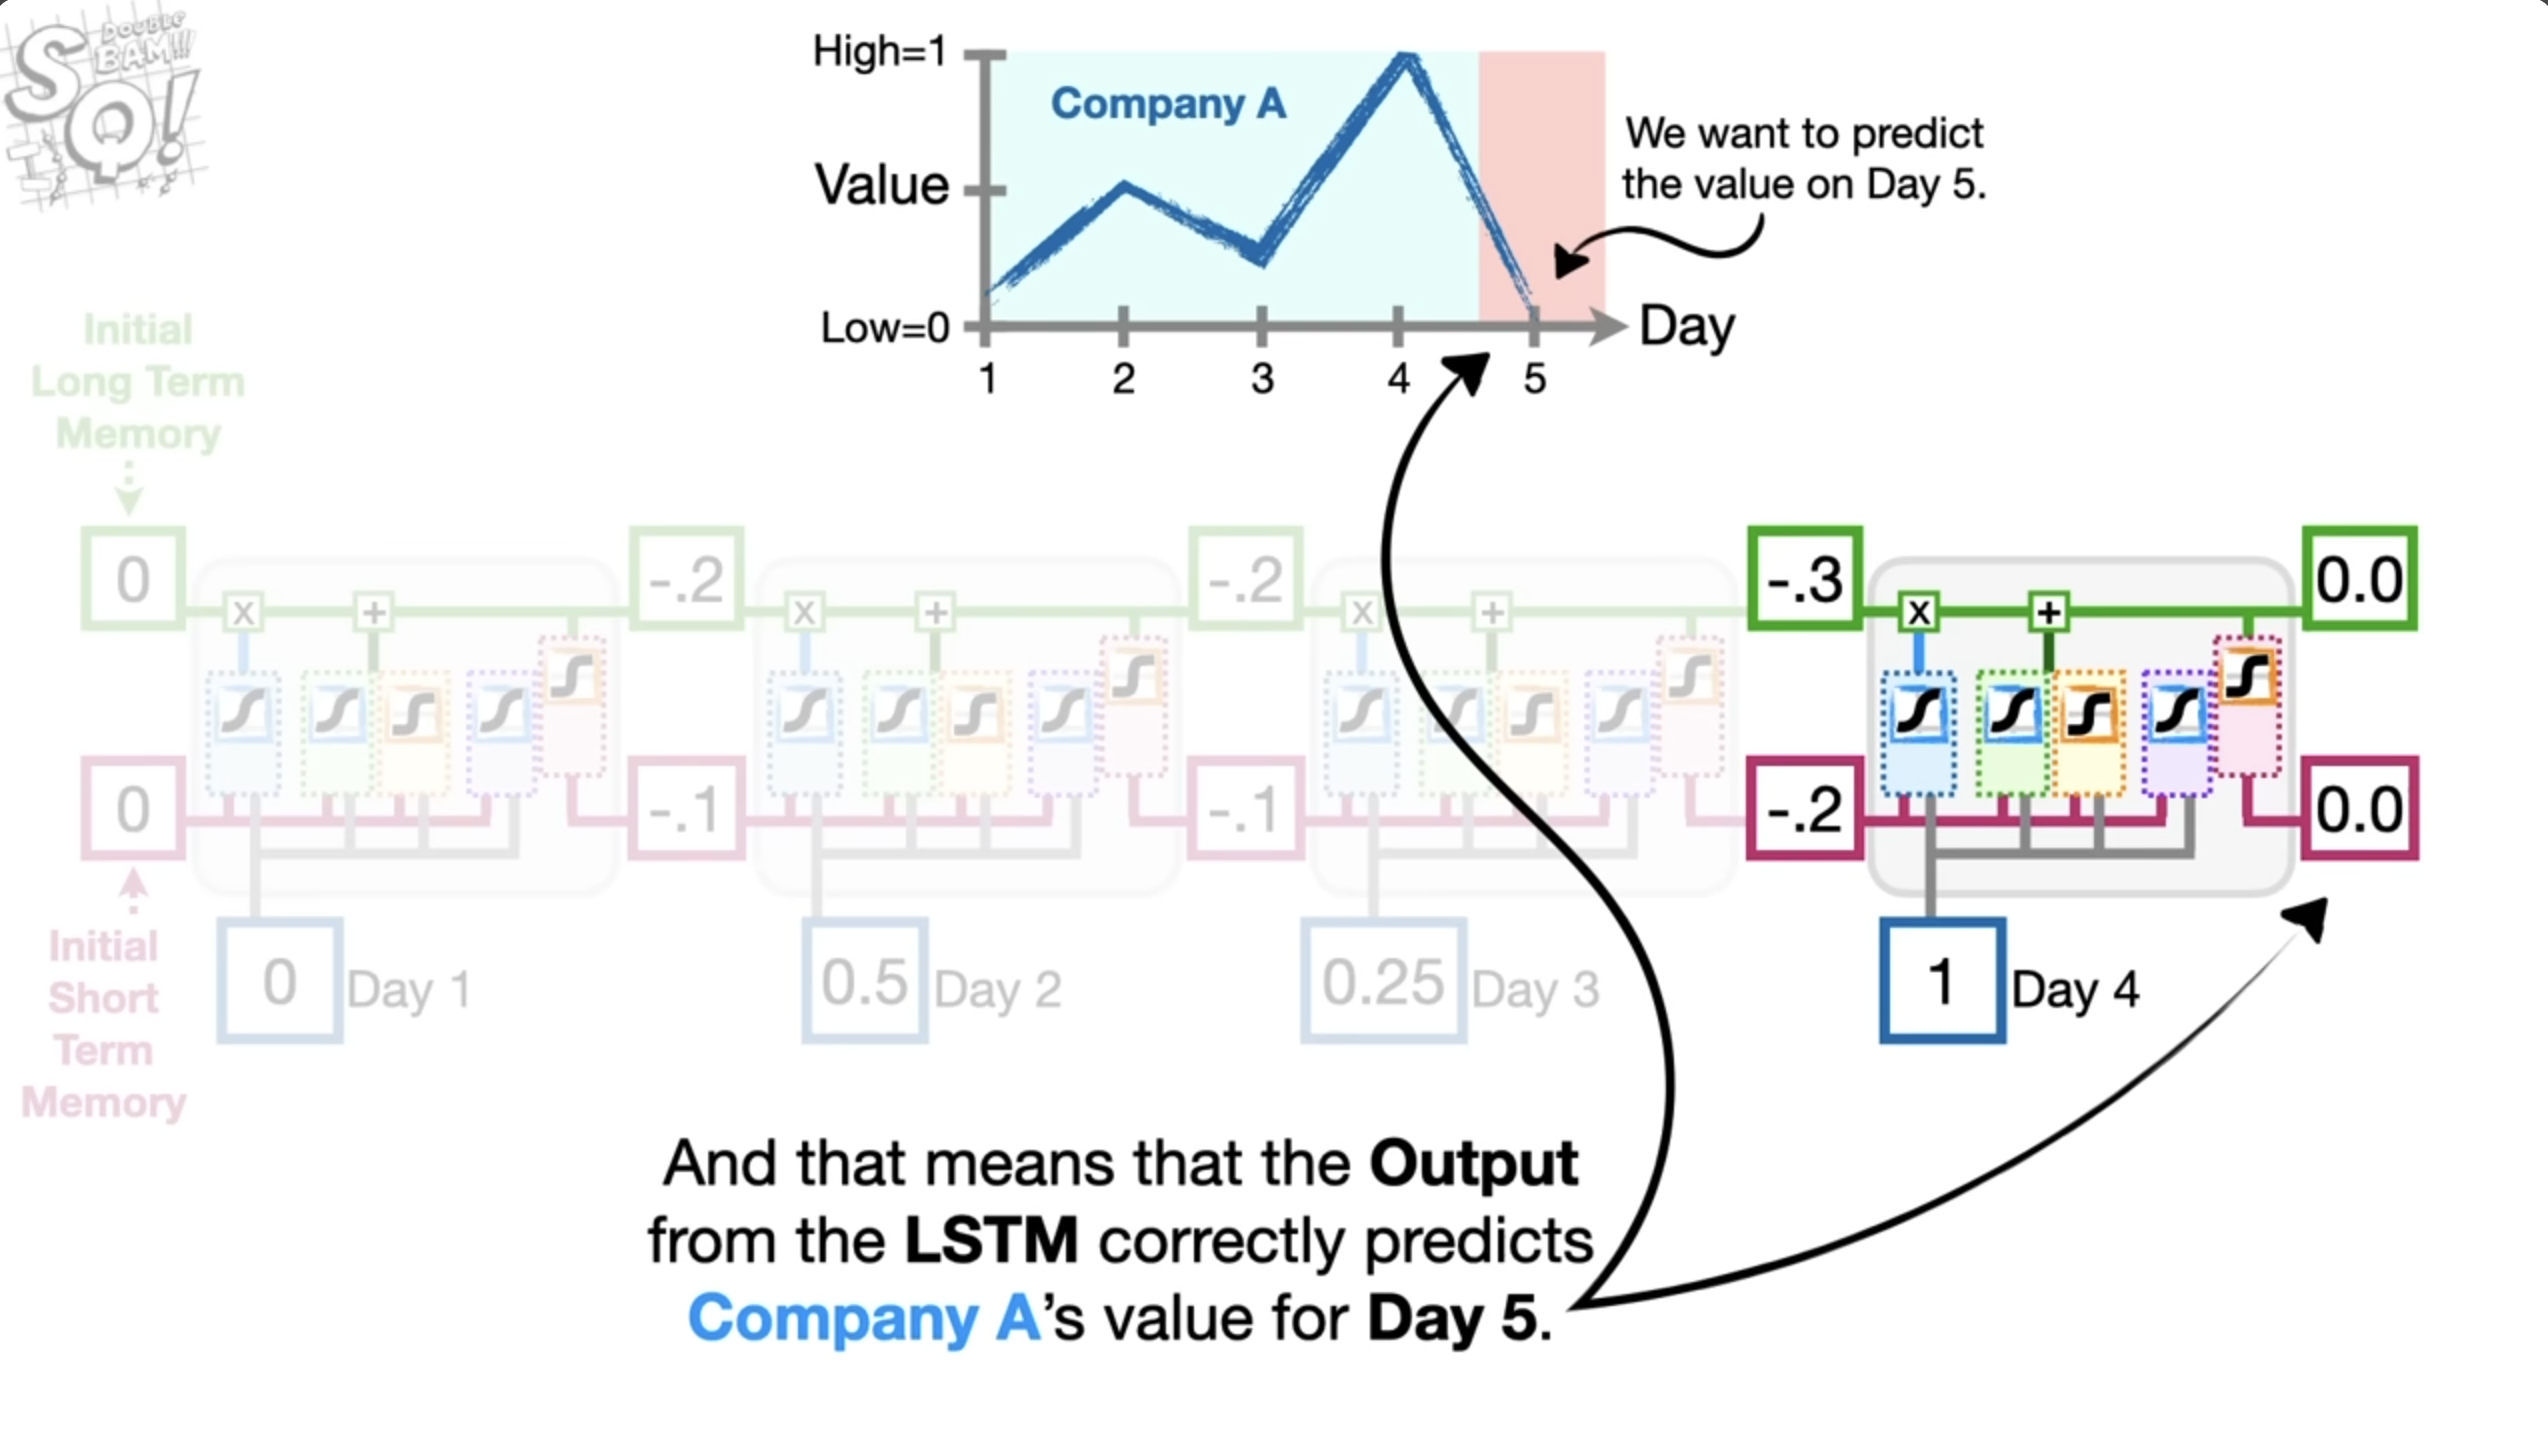

In [26]:
display(Image(filename='LSTM RNN.png'))